Want to explore $p(z)$ and how the solution function maps $e$ to $z$.

In [2]:
from experiments.cubes_2d import get_dataloader, create_model, eval_dci_scores

/mnt/antares_raid/home/jonasb/mambaforge/envs/wscrl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/antares_raid/home/jonasb/Projects/wscrl/repo/experiments/cubes_2d.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(


In [3]:
import logging
from omegaconf import OmegaConf
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset

torch.set_grad_enabled(False)

logger = logging.getLogger()


# EXP_DIR = Path("/mnt/raid/ni/jonasb/wscrl/son_causal_variables_2dcubes_manhattan_equi_child_noise_allow_collisions_25k")
EXP_DIR = Path(
    "/mnt/raid/ni/jonasb/wscrl/son_causal_variables_2dcubes_allow_collisions_25k_1.0_child_noise_scaling_config"
)

model_path = EXP_DIR / "models" / "model.pt"
# model_path = EXP_DIR / "models" / "model_step_150000.pt"
cfg_path = EXP_DIR / "config.yml"

cfg = OmegaConf.load(cfg_path)

model = create_model(cfg)
model.load_state_dict(torch.load(model_path))
model.eval()

device = torch.device(cfg.training.device)
model.to(device)

dim_z = cfg.data.dim_z

CAUSAL_VARIABLES = [
    "pos_x1",
    "pos_y1",
    "pos_x2",
    "pos_y2",
    "pos_x3",
    "pos_y3",
]

CAUSAL_GRAPH = torch.tensor(
    [
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ]
)

In [4]:
val_loader = get_dataloader(cfg, "val", shuffle=False, batchsize=32)

In [5]:
def encode_images(model, loader):
    e1_hat_list = []
    e2_hat_list = []

    z1_hat_list = []
    z2_hat_list = []
    for i, batch in enumerate(loader):
        print(f"Batch {i + 1} / {len(loader)}", end="\r")
        x1, x2, *_ = batch

        x1 = x1.to(device)
        x2 = x2.to(device)

        e1_hat = model.encode_to_noise(x1)
        e2_hat = model.encode_to_noise(x2)

        z1_hat = model.encode_to_causal(x1)
        z2_hat = model.encode_to_causal(x2)

        e1_hat_list.append(e1_hat.cpu().numpy())
        e2_hat_list.append(e2_hat.cpu().numpy())

        z1_hat_list.append(z1_hat.cpu().numpy())
        z2_hat_list.append(z2_hat.cpu().numpy())

    e1_hat = np.concatenate(e1_hat_list)
    e2_hat = np.concatenate(e2_hat_list)

    z1_hat = np.concatenate(z1_hat_list)
    z2_hat = np.concatenate(z2_hat_list)
    return e1_hat, e2_hat, z1_hat, z2_hat

In [6]:
def calculate_causal_variables(model, loader):
    z1_hat_list = []
    z2_hat_list = []
    for i, batch in enumerate(loader):
        print(f"Batch {i + 1} / {len(loader)}", end="\r")
        x1, x2, *_ = batch

        x1 = x1.to(device)
        x2 = x2.to(device)

        z1_hat = model.encode_to_causal(x1)
        z2_hat = model.encode_to_causal(x2)

        z1_hat_list.append(z1_hat.cpu().numpy())
        z2_hat_list.append(z2_hat.cpu().numpy())
    z1_hat = np.concatenate(z1_hat_list)
    z2_hat = np.concatenate(z2_hat_list)
    return z1_hat, z2_hat

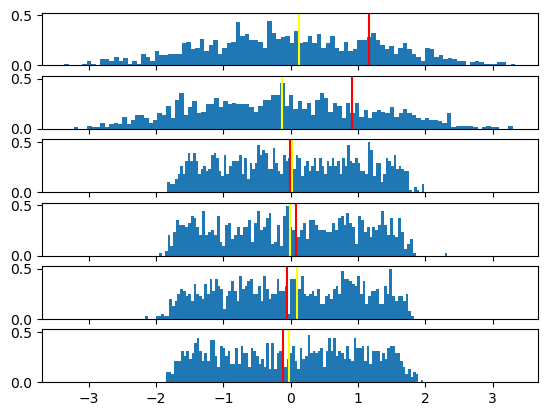

In [7]:
def plot_causal_variables(model, loader):
    e1_hat, e2_hat, z1_hat, z2_hat = encode_images(model, val_loader)

    fig, axes = plt.subplots(nrows=dim_z, sharex=True, sharey=True)

    # z_zero = model.scm.noise_to_causal(torch.zeros(1, dim_z).to(device)).cpu().numpy()

    e1_mean = torch.tensor(e1_hat.mean(axis=0)).unsqueeze(0)
    z_center = model.scm.noise_to_causal(e1_mean.to(device)).cpu().numpy()
    for dim in range(dim_z):
        ax = axes[dim]

        ax.hist(z1_hat[:, dim], bins=100, density=True)

        e1_changed = e1_mean + 1
        e1_changed[:, dim] = e1_mean[:, dim]
        z_changed = model.scm.noise_to_causal(e1_changed.to(device)).cpu().numpy()

        # ax.axvline(z_zero[0, dim], color="red")
        ax.axvline(z_center[0, dim], color="yellow")
        ax.axvline(z_changed[0, dim], color="red")


plot_causal_variables(model, val_loader)

Check if $p(z)$ with $z=s(\widetilde{e_i};e_{\setminus i})$ is independent of $e_{\setminus i}$

(array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([-0.87955672, -0.85482442, -0.83009213, -0.80535984, -0.78062755,
        -0.75589526, -0.73116297, -0.70643067, -0.68169838, -0.65696609,
        -0.63223374, -0.60750145, -0.58276916, -0.55803686, -0.53330457,
        -0.50857228, -0.48383999, -0.4591077 , -0.43437541, -0.40964311,
        -0.38491082, -0.36017853, -0.33544624, -0.31071395, -0.28598166,
        -0.26124936, -0.23651706, -0.21178477, -0.18705246, -0.162320

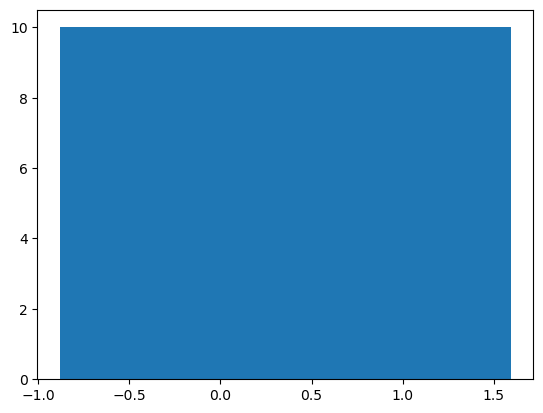

In [13]:
# e1_hat, e2_hat, z1_hat, z2_hat = encode_images(model, val_loader)

num_samples = 1000

e_values = torch.linspace(-1, 1, num_samples)
e_zero = torch.zeros(num_samples, dim_z)
e_one = torch.ones(num_samples, dim_z)

e_combined = e_one.clone()
e_combined[:, 0] = e_values

z_hat = model.scm.noise_to_causal(e_combined.to(device)).cpu().numpy()

plt.hist(z_hat[:, 0], bins=100)

ConditionalAffineTransform: NN gives scale and shift -> have linear relationship between $\widetilde{e}$ and $z$ (keeping the other inputs constant)

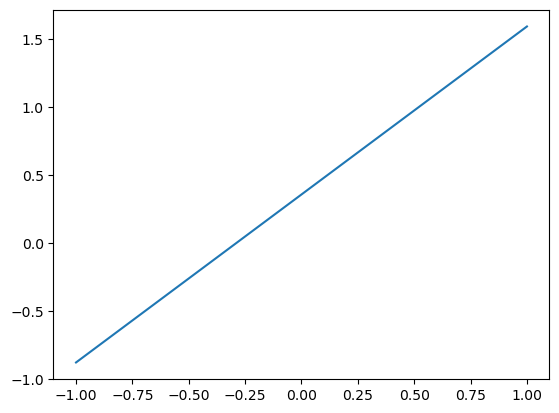

In [9]:
plt.plot(x_values, z_hat[:, 0])